In [1]:
import matplotlib.pyplot as plt
import os

from ultralytics import YOLO
import numpy as np

from transformers import AutoImageProcessor, AutoModelForObjectDetection
import torch
from torch.utils.data import DataLoader, Dataset
from PIL import Image
from PIL import Image
import matplotlib.patches as patches

import json
from pycocotools.coco import COCO

/home/xavier/python-venvs/doom-venv/lib64/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Analyzing Images

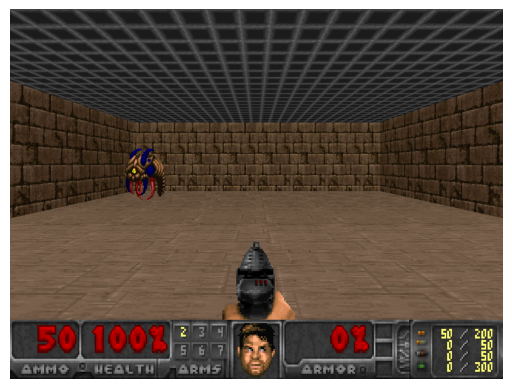

In [2]:
img = plt.imread(os.path.join(os.pardir, "screens", "screen_0001.png"))

plt.imshow(img)
plt.axis('off')
plt.show()

## Testing YOLO Models

In [3]:
# Convert image from float32 (0-1) to uint8 (0-255)
img_uint8 = (img * 255).astype(np.uint8)

# Load the YOLOv8s model
model = YOLO('yolov8s.pt')

# Run inference on the image
results = model(img_uint8)

# Display results
for result in results:
    # result.show()
    result.plot()


0: 480x640 2 persons, 12.1ms
Speed: 1.2ms preprocess, 12.1ms inference, 6.9ms postprocess per image at shape (1, 3, 480, 640)


In [4]:
# Convert image from float32 (0-1) to uint8 (0-255)
img_uint8 = (img * 255).astype(np.uint8)

# Load the YOLOv8n model
model = YOLO('yolov8n.pt')

# Run inference on the image
results = model(img_uint8)

# Display results
for result in results:
    # result.show()
    result.plot()


0: 480x640 (no detections), 13.4ms
Speed: 0.8ms preprocess, 13.4ms inference, 0.2ms postprocess per image at shape (1, 3, 480, 640)


## Vision Transformers

In [5]:
from transformers import DetrImageProcessor, DetrForObjectDetection
import torch
from PIL import Image
import requests

url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open(requests.get(url, stream=True).raw)

print(image.size)

# you can specify the revision tag if you don't want the timm dependency
processor = DetrImageProcessor.from_pretrained(
    "facebook/detr-resnet-50", revision="no_timm")
model = DetrForObjectDetection.from_pretrained(
    "facebook/detr-resnet-50", revision="no_timm")

inputs = processor(images=image, return_tensors="pt")
outputs = model(**inputs)

# convert outputs (bounding boxes and class logits) to COCO API
# let's only keep detections with score > 0.9
target_sizes = torch.tensor([image.size[::-1]])
results = processor.post_process_object_detection(
    outputs, target_sizes=target_sizes, threshold=0.9)[0]

for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
    box = [round(i, 2) for i in box.tolist()]
    print(
        f"Detected {model.config.id2label[label.item()]} with confidence "
        f"{round(score.item(), 3)} at location {box}"
    )

(640, 480)
Detected remote with confidence 0.998 at location [40.16, 70.81, 175.55, 117.98]
Detected remote with confidence 0.996 at location [333.24, 72.55, 368.33, 187.66]
Detected couch with confidence 0.995 at location [-0.02, 1.15, 639.73, 473.76]
Detected cat with confidence 0.999 at location [13.24, 52.05, 314.02, 470.93]
Detected cat with confidence 0.999 at location [345.4, 23.85, 640.37, 368.72]


In [ ]:
image = Image.open(os.path.join(os.pardir, "screens", "screen_0001.png"))

print(image.size)

# convert outputs (bounding boxes and class logits) to COCO API
# let's only keep detections with score > 0.9
target_sizes = torch.tensor([image.size[::-1]])
results = processor.post_process_object_detection(
    outputs, target_sizes=target_sizes, threshold=0.9)[0]

for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
    box = [round(i, 2) for i in box.tolist()]
    print(
        f"Detected {model.config.id2label[label.item()]} with confidence "
        f"{round(score.item(), 3)} at location {box}"
    )

(1024, 768)
Detected train with confidence 0.994 at location [471.98, 482.54, 547.03, 624.22]


## Fine-Tuning with COCO Dataset

This dataset is stored in MS Coco format. The labels from detr-resnet-50 are from the COCO 2017 dataset, and need to be adjusted in order to fine-tune the model.

In [13]:
print(os.getcwd())
coco_ann = COCO(os.path.join(os.pardir, os.pardir, "datasets", "cocodoom", "run-train.json"))

/home/xavier/projects/Deep-RL-Project/notebooks
loading annotations into memory...
Done (t=0.92s)
creating index...
index created!


In [ ]:
# viewing all ids and annotations
for id, ann in zip(coco_ann.getCatIds(), coco_ann.loadCats(coco_ann.getCatIds())):
    print(f"ID: {id} => Name: {ann['name']}")

ID: 1 => Name: POSSESSED
ID: 2 => Name: SHOTGUY
ID: 3 => Name: VILE
ID: 4 => Name: FIRE
ID: 5 => Name: UNDEAD
ID: 6 => Name: TRACER
ID: 7 => Name: SMOKE
ID: 8 => Name: FATSO
ID: 9 => Name: FATSHOT
ID: 10 => Name: CHAINGUY
ID: 11 => Name: TROOP
ID: 12 => Name: SERGEANT
ID: 14 => Name: HEAD
ID: 15 => Name: BRUISER
ID: 16 => Name: BRUISERSHOT
ID: 17 => Name: KNIGHT
ID: 18 => Name: SKULL
ID: 19 => Name: SPIDER
ID: 20 => Name: BABY
ID: 21 => Name: CYBORG
ID: 22 => Name: PAIN
ID: 23 => Name: WOLFSS
ID: 30 => Name: BARREL
ID: 31 => Name: TROOPSHOT
ID: 32 => Name: HEADSHOT
ID: 33 => Name: ROCKET
ID: 34 => Name: PLASMA
ID: 35 => Name: BFG
ID: 36 => Name: ARACHPLAZ
ID: 37 => Name: PUFF
ID: 38 => Name: BLOOD
ID: 39 => Name: TFOG
ID: 42 => Name: EXTRABFG
ID: 43 => Name: MISC0
ID: 44 => Name: MISC1
ID: 45 => Name: MISC2
ID: 46 => Name: MISC3
ID: 47 => Name: MISC4
ID: 53 => Name: MISC10
ID: 54 => Name: MISC11
ID: 55 => Name: MISC12
ID: 56 => Name: INV
ID: 57 => Name: MISC13
ID: 58 => Name: INS
ID: 5

In [19]:
# modifying output labels

# load the model with 
processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50")
model = DetrForObjectDetection.from_pretrained(
    "facebook/detr-resnet-50",
    num_labels=len(coco_ann.getCatIds()),
    ignore_mismatched_sizes=True,
    id2label={id: ann['name'] for id, ann in zip(coco_ann.getCatIds(), coco_ann.loadCats(coco_ann.getCatIds()))},
    label2id={ann['name']: id for id, ann in zip(coco_ann.getCatIds(), coco_ann.loadCats(coco_ann.getCatIds()))}    
)

Some weights of the model checkpoint at facebook/detr-resnet-50 were not used when initializing DetrForObjectDetection: ['model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DetrForObjectDetection were not initialized from the model checkpoin